## Radar verification
#### This notebook shows the code to create the radar data verification plots, using km-resolution building damage data

In [1]:
#load packages
import numpy as np #1.20.3 is default
import pandas as pd
import xarray as xr
import sys
import matplotlib.pyplot as plt
from climada import CONFIG
sys.path.append(str(CONFIG.local_data.func_dir))
import scClim as sc
from scClim.constants import SUB_CH_EXTENT_2056

data_dir = str(CONFIG.local_data.data_dir)
out_dir = str(CONFIG.local_data.out_dir)

#Set the minimum number of buildings per 1km grid cell
min_count=10

#crowdsourced processing version 2.7
version = 27


In [2]:
#load dataset: KGV=Kantonalee Gebäudeversicherung, version 7.1
ds_KGV = xr.open_dataset(data_dir+'/KGV/ds_building_dmg_v71_1000m_wModImp.nc')
ds_KGV = ds_KGV.rename({'value':'imp_observed'})
ds_KGV = ds_KGV.sel(date=slice("2020-08-01",'2023-09-30'))
ds_KGV

<xarray.Dataset>
Dimensions:             (date: 166, chy: 166, chx: 201)
Coordinates:
  * date                (date) datetime64[ns] 2020-08-01 ... 2023-09-22
  * chy                 (chy) float64 1.126e+06 1.126e+06 ... 1.29e+06 1.29e+06
  * chx                 (chx) float64 2.55e+06 2.55e+06 ... 2.748e+06 2.75e+06
    lon                 (chy, chx) float64 ...
    lat                 (chy, chx) float64 ...
Data variables:
    imp_observed        (date, chy, chx) float64 ...
    Versicherungssumme  (date, chy, chx) float64 ...
    n_count             (date, chy, chx) float64 ...
    PAA                 (date, chy, chx) float64 ...
    MDR                 (date, chy, chx) float64 ...
    n_count_exposure    (chy, chx) float64 ...
    Baujahr_exposure    (chy, chx) float64 ...
    value_exposure      (chy, chx) float64 ...
    imp_MESHS           (date, chy, chx) float64 ...
    n_buildings_MESHS   (date, chy, chx) float64 ...
    PAA_MESHS           (date, chy, chx) float64 ...

In [3]:
#add a 4km buffer for n_count and n_count_expposure
ds_KGV['n_dmgs_4km_max']=sc.verification.maximum_filter_nc(ds_KGV.n_count,radius=4)
ds_KGV['n_exp_4km_max']=sc.verification.maximum_filter_nc(ds_KGV.n_count_exposure,radius=4)


# add metorological data

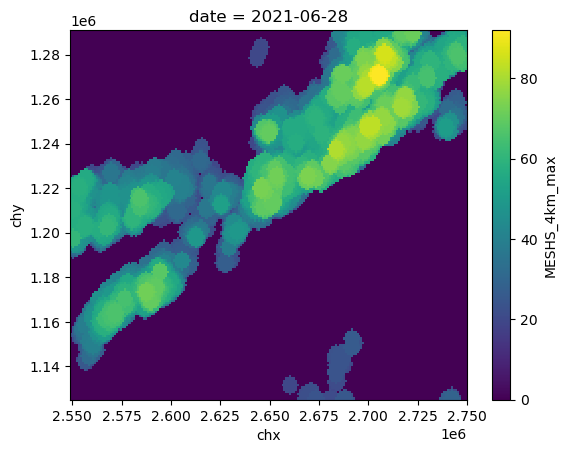

In [4]:
# MESHS
years = np.arange(2020,2023+1)
meshs = xr.open_mfdataset([data_dir+'/V5/MZC/MZC_X1d66_%d.nc'%year for year in years],
                          concat_dim='time', combine='nested', coords='minimal')
meshs = meshs.rename({'time':'date'})
meshs = meshs.sel(chx=slice(SUB_CH_EXTENT_2056[0],SUB_CH_EXTENT_2056[1]),
                  chy=slice(SUB_CH_EXTENT_2056[2],SUB_CH_EXTENT_2056[3]))

#drop dates with no meshs signature
meshs = meshs.MZC.dropna(dim='date',how='all')

#add damage variables (including new dates)
meshs = xr.merge([ds_KGV[['n_count','n_count_exposure','n_dmgs_4km_max','n_exp_4km_max']].drop_vars(['lat','lon']),meshs])
meshs = meshs.rename_vars({'n_count':'n_dmgs','n_count_exposure':'n_exp','MZC':'MESHS'})

meshs.load() #avoid dask error in maximum_filter_nc
#add 4km buffer to MESHS
meshs['MESHS_4km_max']=sc.verification.maximum_filter_nc(meshs.MESHS,radius=4)
meshs['MESHS_4km_max'].sel(date='2021-06-28').plot()


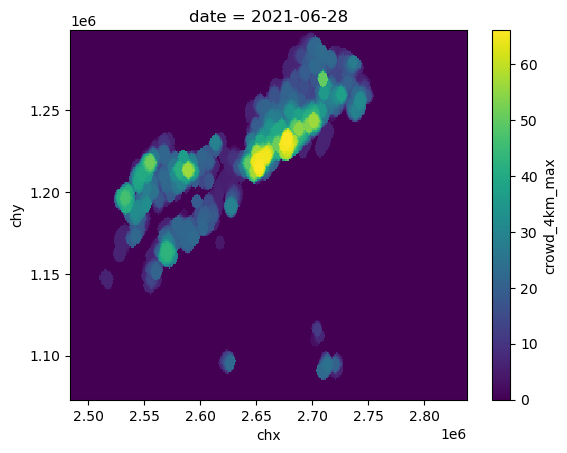

In [5]:
#Add crowdsourced data
ds_crowd = xr.open_dataset(f'{data_dir}/crowd-source/Reports_min25_2020+_V{version}.nc')
ds_crowd = ds_crowd.rename({'time':'date'})

#add damage variables (including new dates)
ds_crowd = xr.merge([ds_KGV[['n_count','n_count_exposure','n_dmgs_4km_max','n_exp_4km_max']].drop_vars(['lat','lon']),ds_crowd])
ds_crowd = ds_crowd.rename_vars({'n_count':'n_dmgs','n_count_exposure':'n_exp','h_smooth':'crowd'})

#add 4km buffer to crowdsourced data
ds_crowd['crowd_4km_max']=sc.verification.maximum_filter_nc(ds_crowd.crowd,radius=4)
ds_crowd['crowd_4km_max'].sel(date='2021-06-28').plot()

In [7]:
#calculate POD per individual claim amd MESHS = 20
POD_p_claim = (meshs.n_dmgs.where(meshs.MESHS>=20).sum()/meshs.n_dmgs.sum()).values
print(f"POD per claim: {POD_p_claim:.2f}")
POD_p_claim_4km = (meshs.n_dmgs.where(meshs.MESHS_4km_max>=20).sum()/meshs.n_dmgs.sum()).values
print(f"POD per claim (4km buffer): {POD_p_claim_4km:.2f}")

#POD for crowd > 20
POD_p_crowd = (ds_crowd.n_dmgs.where(ds_crowd.crowd>=10).sum()/ds_crowd.n_dmgs.sum()).values
print(f"POD per crowd claim: {POD_p_crowd:.2f}")
POD_p_crowd_4km = (ds_crowd.n_dmgs.where(ds_crowd.crowd_4km_max>=10).sum()/ds_crowd.n_dmgs.sum()).values
print(f"POD per crowd claim (4km buffer): {POD_p_crowd_4km:.2f}")


POD per claim: 0.88
POD per claim (4km buffer): 0.96
POD per crowd claim: 0.89
POD per crowd claim (4km buffer): 0.94


In [16]:
#MESHS verification dataframe calculation
#MESHS and damage on 1km grid
verif_MESHS = sc.verification.get_at_gridpoints_from_xr(
    meshs,'MESHS',min_count=min_count
    )

# MESHS extended to 4km (buffer), dmg on 1km grid
verif_MESHS_4km = sc.verification.get_at_gridpoints_from_xr(
    meshs,'MESHS_4km_max',min_count=min_count
    )
df_4km_MESHS, npred_4km = sc.verification.compute_verification_stats(
    verif_MESHS_4km, haz_var = 'MESHS_4km_max'
    )

# dmg extended with 4km buffer, MESHS on 1km grid
meshs_4km_dmg = meshs[['n_dmgs_4km_max','n_exp_4km_max','MESHS']].rename_vars(
    {'n_dmgs_4km_max':'n_dmgs','n_exp_4km_max':'n_exp'}
    )
verif_MESHS_4km_dmg = sc.verification.get_at_gridpoints_from_xr(
    meshs_4km_dmg,'MESHS',min_count=min_count
    )
df_MESHS_4km_dmg, npred_4km_dmg = sc.verification.compute_verification_stats(
    verif_MESHS_4km_dmg, haz_var = 'MESHS'
    )


In [17]:
# crowd verification dataframe calculation
# crowd and damage on 1km grid
verif_crowd = sc.verification.get_at_gridpoints_from_xr(
    ds_crowd, "crowd", min_count=min_count
)

# crowd extended to 4km (buffer), dmg on 1km grid
verif_crowd_4km = sc.verification.get_at_gridpoints_from_xr(
    ds_crowd, "crowd_4km_max", min_count=min_count
)
df_4km_crowd, npred_4km_crowd = sc.verification.compute_verification_stats(
    verif_crowd_4km, haz_var="crowd_4km_max"
)

# dmg extended with 4km buffer, crowd on 1km grid
crowd_4km_dmg = ds_crowd[["n_dmgs_4km_max", "n_exp_4km_max", "crowd"]].rename_vars(
    {"n_dmgs_4km_max": "n_dmgs", "n_exp_4km_max": "n_exp"}
)
verif_crowd_4km_dmg = sc.verification.get_at_gridpoints_from_xr(
    crowd_4km_dmg, "crowd", min_count=min_count
)
df_crowd_4km_dmg, npred_crowd_4km_dmg = sc.verification.compute_verification_stats(
    verif_crowd_4km_dmg, haz_var="crowd"
)

In [18]:
#Define plotting function for general verification plot
def plot_verification(at_centroid_data,df_hazExtend,df_dmgExtend,haz_var = 'MESHS',
                    min_count=None,sec_plot_type='buffer',max_x=None,ax=None,
                    plot_bins=True,plot_n_cells = True,
                    plot_ratio=True,plot_title=True,legend_anchor=(0.5, -0.25),
                    lw1=4,lw2=2):

    # Define labels for secondary plot
    if sec_plot_type == 'buffer':
        lbl1 = '4km hazard buffer'
        lbl2 = '4km damage buffer'
    elif sec_plot_type == 'shifted':
        pd.testing.assert_frame_equal(df_hazExtend,df_dmgExtend)
        lbl = 'with hail drift'

    if ax is None:
        fig,ax=plt.subplots(figsize=(6,4))
    else:
        fig = ax.get_figure()

    # Calculate verification statistics (POD, FAR, HSS)
    df, npred = sc.verification.compute_verification_stats(at_centroid_data, haz_var = haz_var)

    # Select x-axis range
    if max_x is None:
        x=df.index[:]#[1:]
        x_haz = df_hazExtend.index[:]
        x_dmg = df_dmgExtend.index[:]
    else:
        imax = np.where(df.index == max_x)[0][0]
        x=df.index[0:imax]
        x_haz = df_hazExtend.index[0:np.where(df_hazExtend.index == max_x)[0][0]]
        x_dmg = df_dmgExtend.index[0:np.where(df_dmgExtend.index == max_x)[0][0]]

    # Plot verification statistics
    #POD
    h2=ax.plot(x,df.POD[x],color='blue',lw=lw1, ls = 'solid', label = 'POD')
    ax.plot(x_haz,df_hazExtend.POD[x_haz],color='blue',lw=lw2, ls = 'dashed',
            label = f'POD\n({lbl1})',alpha=0.5)
    #FAR
    h1=ax.plot(x,df.FAR[x],color='r',linewidth=lw1, label = 'FAR')
    ax.plot(x_dmg,df_dmgExtend.FAR[x_dmg],color='r',linewidth=lw2,
            label = f'FAR\n({lbl2})',linestyle = 'dashed',alpha=0.5)
    #HSS
    h2=ax.plot(x,df.HSS[x],color='k',lw=lw1, ls = 'solid', label = 'HSS')
    if sec_plot_type == 'shifted':
        ax.plot(x,df_hazExtend.HSS[x],color='k',lw=lw2, ls = 'dashed',
                 label = f'HSS\n({lbl})',alpha=0.5)

    # Add title
    if plot_title:
        ax.set_title(f'Haz: {haz_var}, only gridcells with >{min_count} buildings')

    # Add ratio of total predictions
    if plot_ratio and sec_plot_type == 'buffer':
        ax.plot(x,df.PRED[x]/npred,color='grey',ls='dotted',lw=lw1,
                label='Ratio of\ntotal predictions')

    # Add number of gridcells per intensity bin
    if plot_n_cells:
        ax.text(0.97,0.97,'n = {}'.format(npred),horizontalalignment='right',zorder=3,
            verticalalignment='top', transform=ax.transAxes, bbox=dict(facecolor='dimgrey', alpha=0.5))

    # Format axis and legend
    ax.set(yticks=np.arange(0,1.1,0.2),xlim=(x[0],x[-1]),ylim=(0,1))
    ax.set_xlabel(sc.constants.INT_LABEL_DICT[haz_var].replace('Intensity: ',''))
    ax.legend(loc='upper center',bbox_to_anchor=legend_anchor,ncol=3) #(x,y, width, height)
    #ax.legend(ncol=2,loc='upper left')
    ax.grid(linestyle='dotted')

    #Add bins of the number of gridcells per intensity bin
    if plot_bins:
        dmg_bin_size=sc.constants.DMG_BIN_DICT[haz_var]
        #create dataframe with number of gridcells in each bin (not number of exposure points!)
        df_n_cells = at_centroid_data.loc[at_centroid_data.n_exp>min_count,:].groupby(haz_var).count()
        #select only relevant range (same as in verification dataframe)
        df_n_cells = df_n_cells.loc[x,:]
        df_n_cells = df_n_cells.rename(columns={'n_exp':'count_cells'})
        sc.E.plot_dmg_bin(df_n_cells,ax,pl_var='count_cells',color='grey',bin_size=dmg_bin_size)

    return fig, ax, df

### Plot figure with MESHS and crowdsourced verification statistics

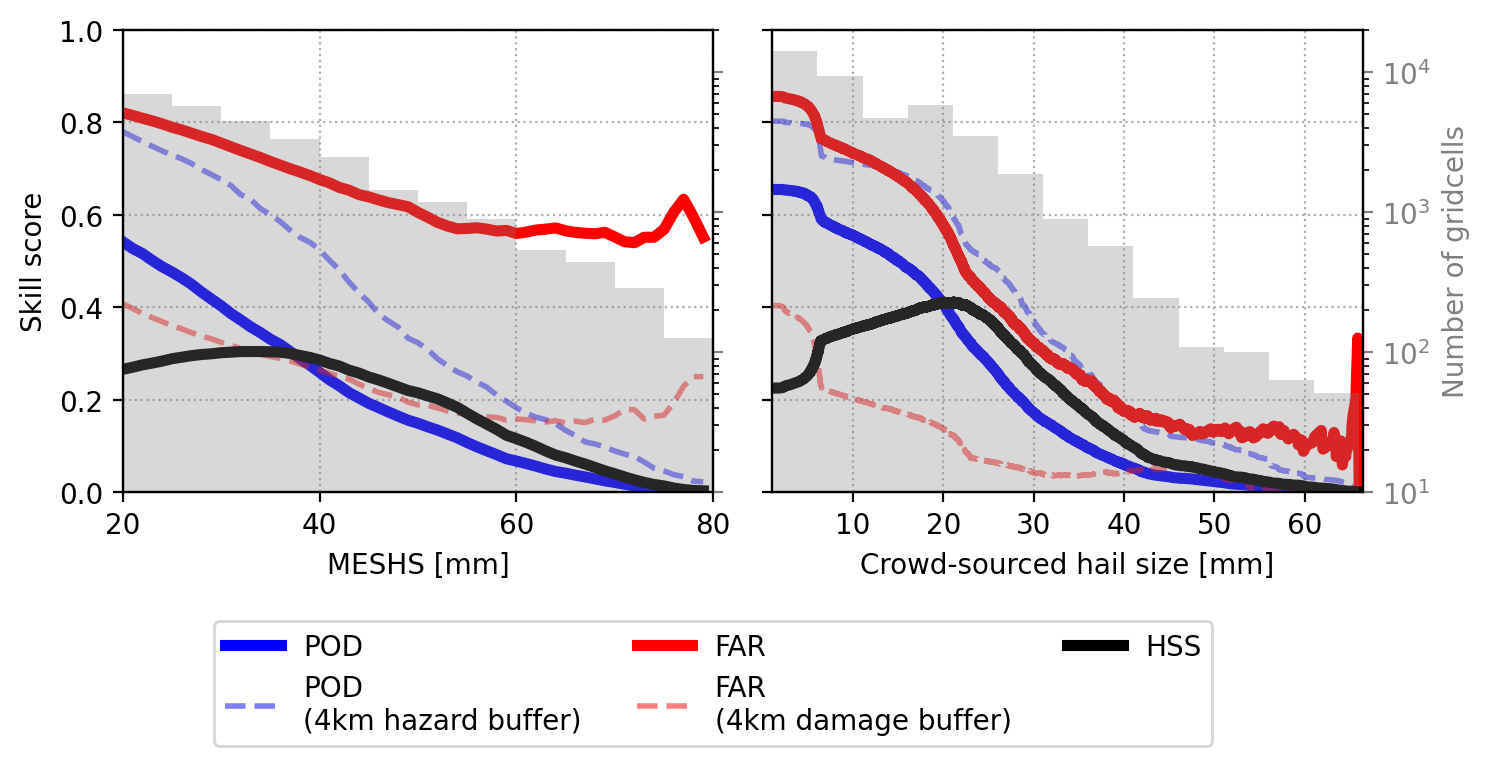

In [19]:
#Initialise plot
fontsize = 10
fig,axes = plt.subplots(1,2,figsize=(8,3),sharey=True,gridspec_kw={'wspace':0.1},dpi=200)

#Plot MESHS verification
fig1, ax1, _ = plot_verification(verif_MESHS,df_4km_MESHS,df_MESHS_4km_dmg,'MESHS',min_count,max_x=80,
                                 ax=axes[0],plot_n_cells = False,plot_ratio=False,plot_title=False)
ax1.get_legend().remove()
ax1.set(xticks=[20,40,60,80])

#Plot crowd verification
fig2, ax2, _ = plot_verification(verif_crowd,df_4km_crowd,df_crowd_4km_dmg,'crowd',min_count,max_x=None,
                                 ax=axes[1],plot_n_cells = False,plot_ratio=False,plot_title=False,
                                 legend_anchor=(-0.1, -0.25))
ax2.set(xticks=[10,20,30,40,50,60])

#add legend
for i,ax in enumerate(fig.get_axes()[2:]):
    ax.set(ylim=(10,2e4),yscale='log')
    ax.tick_params(axis='y',color='grey',labelcolor='grey',labelsize=fontsize)

    if not i==1:
        ax.set(ylabel=None,yticklabels=[])
    else:
        ax.set_ylabel('Number of gridcells',color='grey',fontsize=fontsize)
#adjust all axes:
for ax in axes:
    ax.tick_params(axis='both', labelsize=fontsize)
    ax.xaxis.label.set_size(fontsize)
    ax.yaxis.label.set_size(fontsize)
ax1.set(ylabel='Skill score')

#Save figure
fig.savefig(f'{out_dir}/paper_crowd/verif_all_10.png',dpi=300,bbox_inches='tight')

c:\users\timschmi\documents\phd\code\scclim\scClim\verification.py:133: RuntimeWarning: divide by zero encountered in log
  SEDI=(np.log(POFD)-np.log(POD)+np.log(1-POD)-np.log(1-POFD))/(np.log(POFD)+np.log(POD)+np.log(1-POD)+np.log(1-POFD))
c:\users\timschmi\documents\phd\code\scclim\scClim\verification.py:133: RuntimeWarning: invalid value encountered in divide
  SEDI=(np.log(POFD)-np.log(POD)+np.log(1-POD)-np.log(1-POFD))/(np.log(POFD)+np.log(POD)+np.log(1-POD)+np.log(1-POFD))
c:\users\timschmi\documents\phd\code\scclim\scClim\verification.py:133: RuntimeWarning: divide by zero encountered in log
  SEDI=(np.log(POFD)-np.log(POD)+np.log(1-POD)-np.log(1-POFD))/(np.log(POFD)+np.log(POD)+np.log(1-POD)+np.log(1-POFD))
c:\users\timschmi\documents\phd\code\scclim\scClim\verification.py:133: RuntimeWarning: invalid value encountered in divide
  SEDI=(np.log(POFD)-np.log(POD)+np.log(1-POD)-np.log(1-POFD))/(np.log(POFD)+np.log(POD)+np.log(1-POD)+np.log(1-POFD))


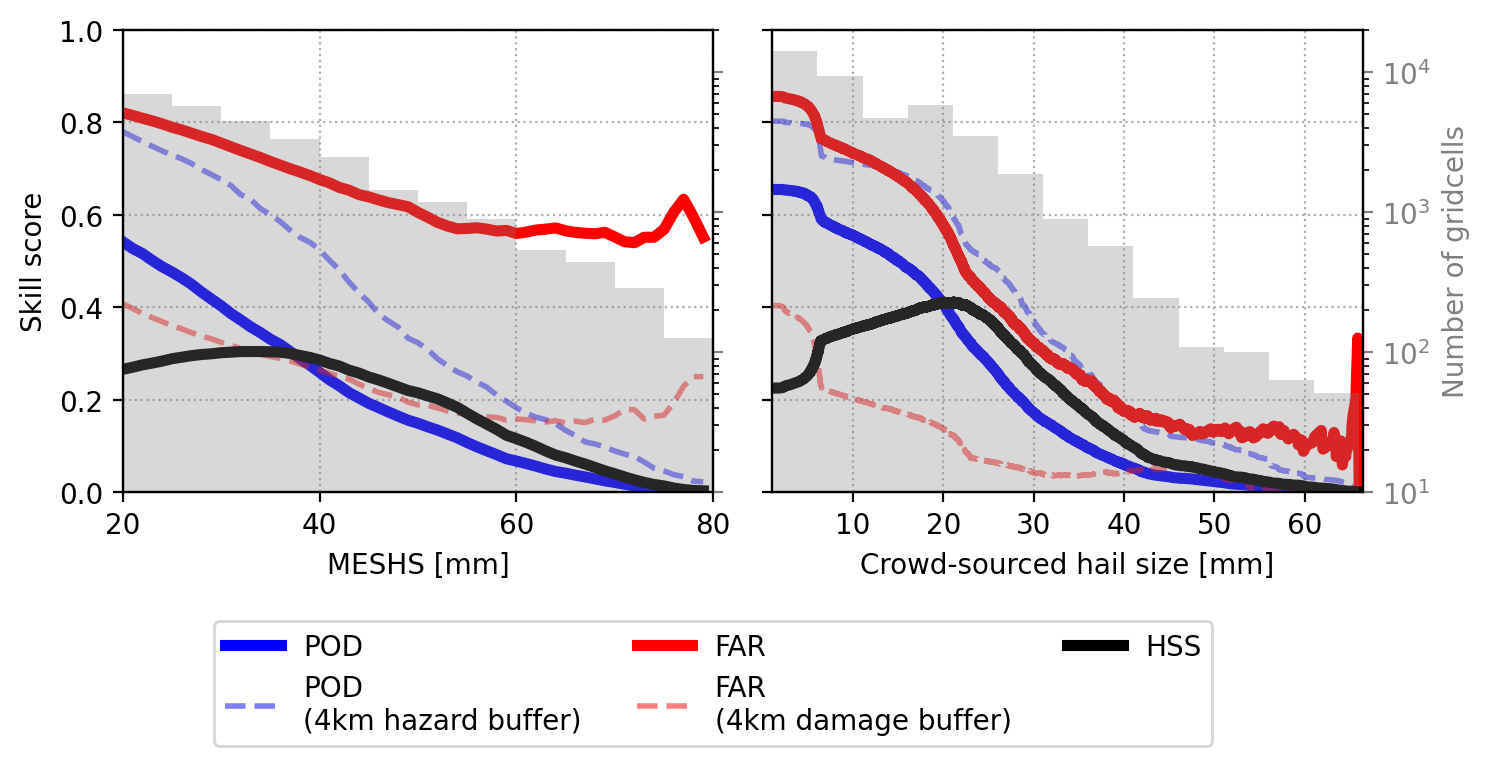

## Additional plots 

c:\users\timschmi\documents\phd\code\scclim\scClim\verification.py:133: RuntimeWarning: divide by zero encountered in log
  SEDI=(np.log(POFD)-np.log(POD)+np.log(1-POD)-np.log(1-POFD))/(np.log(POFD)+np.log(POD)+np.log(1-POD)+np.log(1-POFD))
c:\users\timschmi\documents\phd\code\scclim\scClim\verification.py:133: RuntimeWarning: invalid value encountered in divide
  SEDI=(np.log(POFD)-np.log(POD)+np.log(1-POD)-np.log(1-POFD))/(np.log(POFD)+np.log(POD)+np.log(1-POD)+np.log(1-POFD))


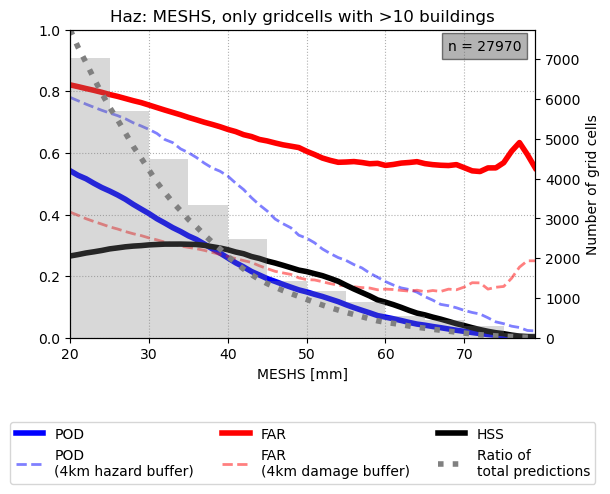

In [10]:
max_x = 80
fig, ax, _ =plot_verification(verif_MESHS,df_4km_MESHS,df_MESHS_4km_dmg,'MESHS',min_count,max_x=max_x)

c:\users\timschmi\documents\phd\code\scclim\scClim\verification.py:133: RuntimeWarning: divide by zero encountered in log
  SEDI=(np.log(POFD)-np.log(POD)+np.log(1-POD)-np.log(1-POFD))/(np.log(POFD)+np.log(POD)+np.log(1-POD)+np.log(1-POFD))
c:\users\timschmi\documents\phd\code\scclim\scClim\verification.py:133: RuntimeWarning: invalid value encountered in divide
  SEDI=(np.log(POFD)-np.log(POD)+np.log(1-POD)-np.log(1-POFD))/(np.log(POFD)+np.log(POD)+np.log(1-POD)+np.log(1-POFD))


[Text(0, 0.5, 'POD, FAR, HSS')]

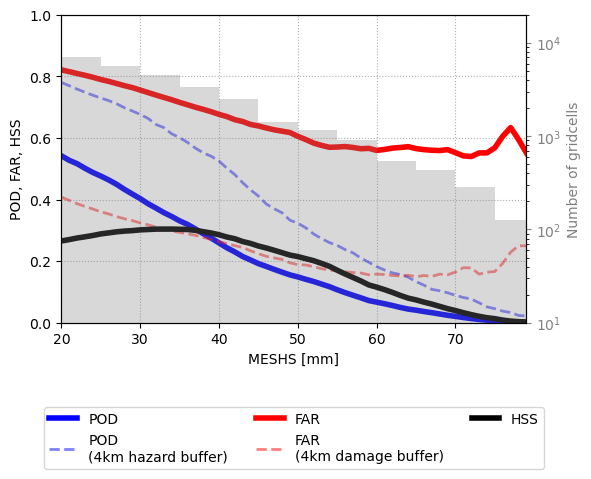

In [11]:
max_x = 80
fig, ax, _ =plot_verification(verif_MESHS,df_4km_MESHS,df_MESHS_4km_dmg,'MESHS',
                              min_count,max_x=max_x,plot_n_cells = False,
                              plot_ratio=False,plot_title=False)
ax2 = fig.get_axes()[1]
ax2.set(ylim=(10,2e4),yscale='log')
ax2.tick_params(axis='y',color='grey',labelcolor='grey',labelsize=10)
ax2.set_ylabel('Number of gridcells',color='grey',fontsize=10)

ax.set(ylabel='POD, FAR, HSS')

c:\users\timschmi\documents\phd\code\scclim\scClim\verification.py:133: RuntimeWarning: divide by zero encountered in log
  SEDI=(np.log(POFD)-np.log(POD)+np.log(1-POD)-np.log(1-POFD))/(np.log(POFD)+np.log(POD)+np.log(1-POD)+np.log(1-POFD))
c:\users\timschmi\documents\phd\code\scclim\scClim\verification.py:133: RuntimeWarning: invalid value encountered in divide
  SEDI=(np.log(POFD)-np.log(POD)+np.log(1-POD)-np.log(1-POFD))/(np.log(POFD)+np.log(POD)+np.log(1-POD)+np.log(1-POFD))


[(10.0, 20000.0), None]

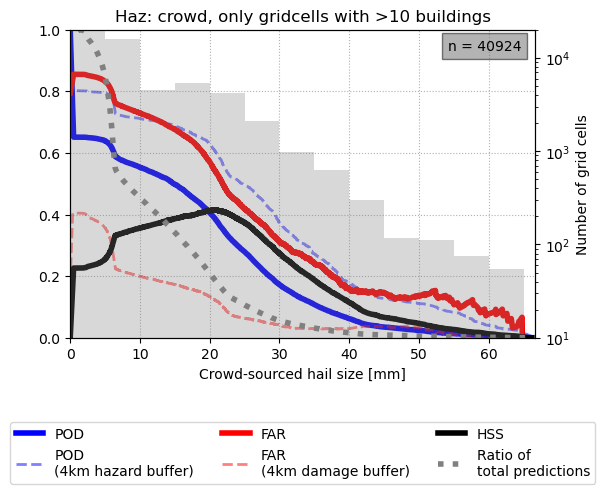

In [10]:
#VERSION 3.3
max_x = None
fig, ax, _ =plot_verification(verif_crowd,df_4km_crowd,df_crowd_4km_dmg,'crowd',min_count,max_x=max_x)
ax2 = fig.get_axes()[1]
ax2.set(ylim=(10,2e4),yscale='log')

c:\users\timschmi\documents\phd\code\scclim\scClim\verification.py:133: RuntimeWarning: divide by zero encountered in log
  SEDI=(np.log(POFD)-np.log(POD)+np.log(1-POD)-np.log(1-POFD))/(np.log(POFD)+np.log(POD)+np.log(1-POD)+np.log(1-POFD))
c:\users\timschmi\documents\phd\code\scclim\scClim\verification.py:133: RuntimeWarning: invalid value encountered in divide
  SEDI=(np.log(POFD)-np.log(POD)+np.log(1-POD)-np.log(1-POFD))/(np.log(POFD)+np.log(POD)+np.log(1-POD)+np.log(1-POFD))


[(10.0, 20000.0), None]

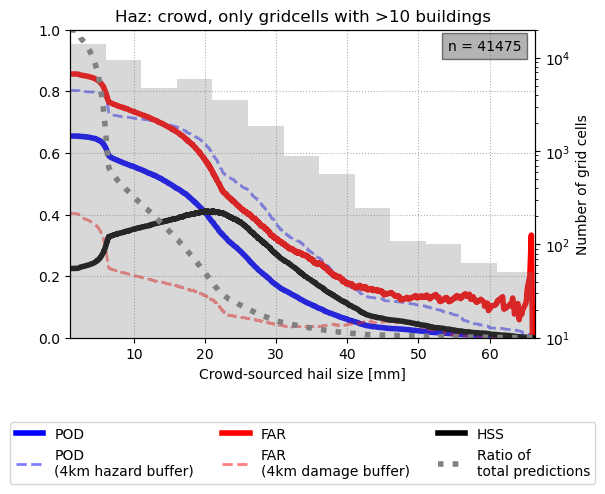

In [12]:
max_x = None
fig, ax, _ =plot_verification(verif_crowd,df_4km_crowd,df_crowd_4km_dmg,'crowd',min_count,max_x=max_x)
ax2 = fig.get_axes()[1]
ax2.set(ylim=(10,2e4),yscale='log')